In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# global imports
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# local imports
sys.path.append('../src/') # local path
import dautils

### Read dataframe

In [2]:
# read dataset
df = pd.read_csv('../data/adult_continuous.csv', na_values='?')
# remove unused columns
del df['fnlwgt']
del df['education-num']
# remove special characters in column names and values
df.columns = df.columns.str.replace("[-&]", "")
df = df.replace('[-&()]', '', regex=True)
df.info()

C:\Users\ruggieri\AppData\Local\Temp\ipykernel_16792\914326719.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("[-&]", "")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            48842 non-null  int64 
 1   workclass      46043 non-null  object
 2   education      48842 non-null  object
 3   maritalstatus  48842 non-null  object
 4   occupation     46033 non-null  object
 5   relationship   48842 non-null  object
 6   race           48842 non-null  object
 7   sex            48842 non-null  object
 8   capitalgain    48842 non-null  int64 
 9   capitalloss    48842 non-null  int64 
 10  hoursperweek   48842 non-null  int64 
 11  nativecountry  47985 non-null  object
 12  class          48842 non-null  object
dtypes: int64(4), object(9)
memory usage: 4.8+ MB


In [3]:
# missing values imputation (for Decision Trees)
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [4]:
# nominal-ordinal-continuous partition of predictive attributes
nominal_atts = ['workclass', 'maritalstatus', 'occupation', 'relationship', 'race', 'sex', 'nativecountry']
ordinal_atts = ['education']
continuous_atts = ['age', 'capitalgain', 'capitalloss', 'hoursperweek']
# class attribute
target = 'class'
# predictive and all atts
pred_atts = nominal_atts + ordinal_atts + continuous_atts
all_atts = pred_atts + [target]

In [5]:
# forcing encoding of ordinal attributes (consistent with the order) and class attribute (0=negatives, 1=positives)
decode = {
    'education': {
        1:'Preschool', 2:'1st4th', 3:'5th6th', 4:'7th8th', 5:'9th', 6:'10th', 7:'11th',
        8:'12th', 9:'HSgrad', 10:'Somecollege', 11:'Assocvoc', 12:'Assocacdm', 13:'Bachelors', 
        14:'Masters', 15:'Profschool', 16:'Doctorate' 
    },
    'class': {
        0: '<=50K', 1: '>50K'
    }
}
# encode nominal (as categories), ordinal+target (as int), passing the encoding of ordinal+target
df_code = dautils.Encode(nominal=nominal_atts, ordinal=ordinal_atts+[target], decode=decode, onehot=True, prefix_sep="_")
df_encoded_onehot = df_code.fit_transform(df)
df_encoded_onehot.head()

,age,workclass_Federalgov,workclass_Localgov,workclass_Neverworked,workclass_Private,workclass_Selfempinc,workclass_Selfempnotinc,workclass_Stategov,workclass_Withoutpay,education,...,nativecountry_PuertoRico,nativecountry_Scotland,nativecountry_South,nativecountry_Taiwan,nativecountry_Thailand,nativecountry_TrinadadTobago,nativecountry_UnitedStates,nativecountry_Vietnam,nativecountry_Yugoslavia,class
0,39,0,0,0,0,0,0,1,0,13,...,0,0,0,0,0,0,1,0,0,0
1,50,0,0,0,0,0,1,0,0,13,...,0,0,0,0,0,0,1,0,0,0
2,38,0,0,0,1,0,0,0,0,9,...,0,0,0,0,0,0,1,0,0,0
3,53,0,0,0,1,0,0,0,0,7,...,0,0,0,0,0,0,1,0,0,0
4,28,0,0,0,1,0,0,0,0,13,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# encoded atts names
encoded_pred_atts = df_code.encoded_atts(pred_atts)
# train a decision tree
from sklearn.tree import DecisionTreeClassifier

X, y = df_encoded_onehot[encoded_pred_atts], df_encoded_onehot[target]
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=3)

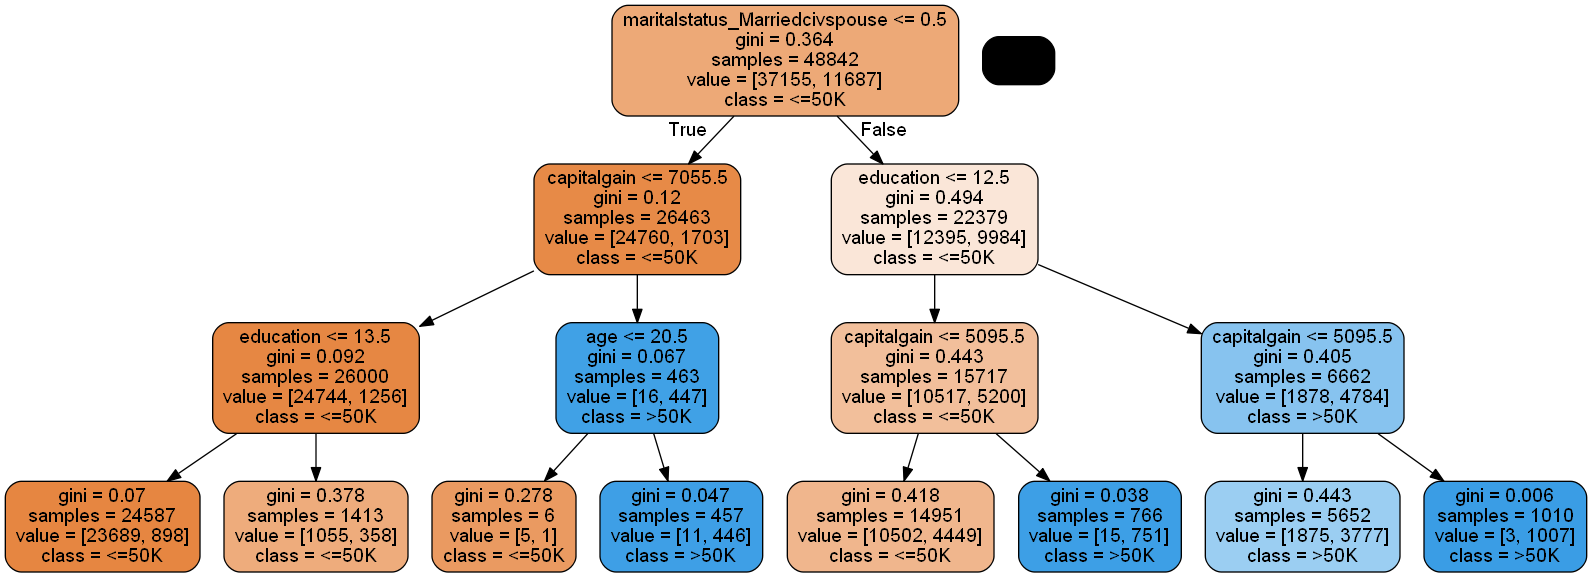

In [7]:
# visualize the decision tree
from sklearn import tree
from IPython.display import Image
import pydotplus

dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=encoded_pred_atts, # attributes names
                                class_names=df_code.decode[target], # class labels
                                filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [38]:
# pip install --upgrade linear-tree
from sklearn.linear_model import RidgeClassifier
from lineartree import LinearTreeClassifier

clf2 = LinearTreeClassifier(base_estimator=RidgeClassifier())
clf2.fit(X, y)

D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.65531e-13): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.13845e-13): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.64341e-13): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.98782e-13): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matr

D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.73062e-13): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.23889e-12): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.33176e-13): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.5013e-12): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matri

D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.32077e-13): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.35199e-13): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.22932e-13): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.43942e-13): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matr

D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.84235e-13): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.67411e-13): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.7047e-12): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.48941e-13): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matri

D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.45013e-12): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.61798e-13): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.30503e-12): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.20472e-13): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matr

D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.68206e-12): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.1241e-13): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.46236e-12): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.40217e-13): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matri

D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.58372e-12): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.47531e-12): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.73749e-12): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.00525e-12): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matr

D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.43536e-12): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.17573e-12): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
D:\FILES\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.62441e-12): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


LinearTreeClassifier(base_estimator=RidgeClassifier())

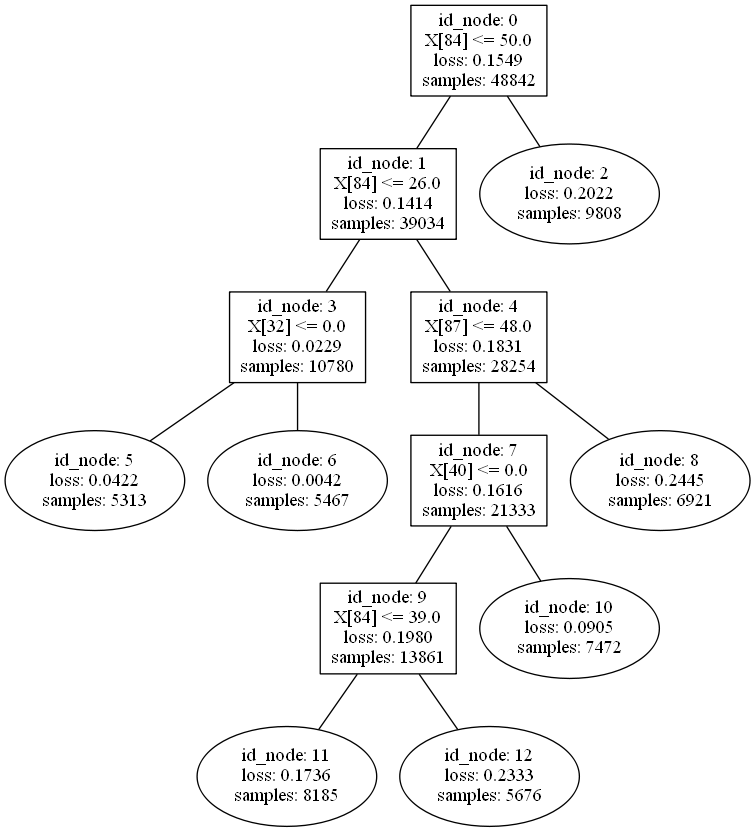

In [39]:
clf2.plot_model()

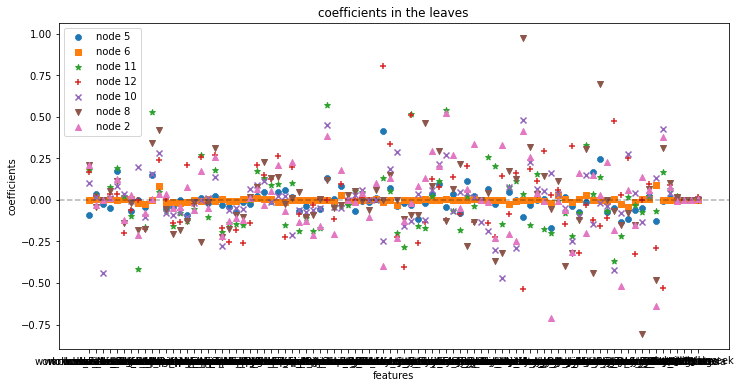

In [50]:
## Extract coefficients at the leaves
leaves = clf2.summary(only_leaves=True)
markers = '8s*+xv^.'

plt.figure(figsize=(12,6))
for m,(i,l) in enumerate(leaves.items()):
    plt.scatter(range(X.shape[1]), l['models'].coef_, marker=markers[m], label="node {}".format(i))

plt.axhline(0, c='black', linestyle='--', alpha=0.3)
plt.title('coefficients in the leaves')
plt.xticks(range(X.shape[1]), X.columns)
plt.ylabel('coefficients'); plt.xlabel('features')
plt.legend()

In [49]:
s = clf2.summary()
s

{0: {'col': 84,
  'th': 50.0,
  'loss': 0.15493,
  'samples': 48842,
  'children': (1, 2),
  'models': (RidgeClassifier(), RidgeClassifier())},
 1: {'col': 84,
  'th': 26.0,
  'loss': 0.14144,
  'samples': 39034,
  'children': (3, 4),
  'models': (RidgeClassifier(), RidgeClassifier())},
 3: {'col': 32,
  'th': 0.0,
  'loss': 0.02291,
  'samples': 10780,
  'children': (5, 6),
  'models': (RidgeClassifier(), RidgeClassifier())},
 4: {'col': 87,
  'th': 48.0,
  'loss': 0.18309,
  'samples': 28254,
  'children': (7, 8),
  'models': (RidgeClassifier(), RidgeClassifier())},
 7: {'col': 40,
  'th': 0.0,
  'loss': 0.16163,
  'samples': 21333,
  'children': (9, 10),
  'models': (RidgeClassifier(), RidgeClassifier())},
 9: {'col': 84,
  'th': 39.0,
  'loss': 0.19804,
  'samples': 13861,
  'children': (11, 12),
  'models': (RidgeClassifier(), RidgeClassifier())},
 5: {'loss': 0.04216,
  'samples': 5313,
  'models': RidgeClassifier(),
  'classes': array([0, 1])},
 6: {'loss': 0.00421,
  'samples':

In [ ]:
# TBD: print model tree as text


### Decision tree paths to CLP rules 

In [53]:
from clp4xai import Model2CLP

m2clp = Model2CLP(pred_atts, target, df_code)
m2clp.model(clf)
m2clp.instance('F', 0) # factual
m2clp.instance('CF', 1) # one counter-factual
m2clp.constraint("CF.age >= F.age") # or any other linear expression on continuous/ordinal features
m2clp.constraint("CF.capitalgain >= 2*CF.capitalloss + 20") # or any other linear expression on continuous/ordinal features
m2clp.constraint("CF.sex = Male") # equality on nominal features
m2clp.constraint("CF.race = F.race") # equality on nominal features
#m2clp.constraint("CF.education >= Somecollege") # inequality on ordinal features (to be implemented)
m2clp.constraint("CF.nativecountry=UnitedStates <=> F.nativecountry=France") # iff on nominal features counterfactual from US iff factual from France
#m2clp.constraint("distance(f, cf, l1) < 0.2")
#m2clp.constraint("sparsity(f, cf, l1) < 0.2")
#m2clp.constraint("CF.race in (black, amerindianeskimo)") # in operator on nominal features (to be implemented)
m2clp.toCLP()

:- use_module(library(clpr)).
:- use_module(library(lists)).
% feature(i, constant) :- constant name for the i-th variable
feature(0, vworkclass_Federalgov).
feature(1, vworkclass_Localgov).
feature(2, vworkclass_Neverworked).
feature(3, vworkclass_Private).
feature(4, vworkclass_Selfempinc).
feature(5, vworkclass_Selfempnotinc).
feature(6, vworkclass_Stategov).
feature(7, vworkclass_Withoutpay).
feature(8, vmaritalstatus_Divorced).
feature(9, vmaritalstatus_MarriedAFspouse).
feature(10, vmaritalstatus_Marriedcivspouse).
feature(11, vmaritalstatus_Marriedspouseabsent).
feature(12, vmaritalstatus_Nevermarried).
feature(13, vmaritalstatus_Separated).
feature(14, vmaritalstatus_Widowed).
feature(15, voccupation_Admclerical).
feature(16, voccupation_ArmedForces).
feature(17, voccupation_Craftrepair).
feature(18, voccupation_Execmanagerial).
feature(19, voccupation_Farmingfishing).
feature(20, voccupation_Handlerscleaners).
feature(21, voccupation_Machineopinspct).
feature(22, voccupation_O